In [60]:
import sys
sys.path.insert(0,'python')
#from fast_rw import *
import numpy.ma as ma
import pylab as plt
%matplotlib inline
#data = parallel_rw_pkl(None, 'inter_sent%i'%2, 'r')
#mask = parallel_rw_pkl(None, 'inter_sentm%i'%2, 'r')
#modis_sent = ma.array(data, mask=mask)

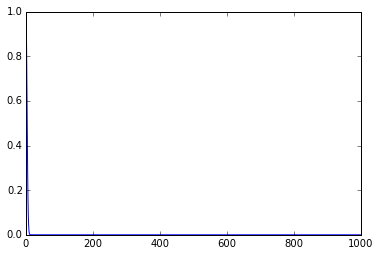

In [61]:
N = 1000
sigma = 100
gaus1 = []
for k in range(N):
    gaus1.append(np.exp(-1*0.5*(k*np.pi*sigma/(N*1.))**2))
plt.plot(gaus1)

In [62]:
from scipy import signal
import scipy
def gaussian(xwin, ywin, xstd, ystd, angle, norm = False):
    win = 2.*max(xwin, ywin)
    if win <=0:
        print 'Window size can not be 0 or less, xwin: %s ywin: %s'%(xwin, ywin)
        pass
    else:
        
        sclx = (win*1.)/(xwin*1.)
        scly = (win*1.)/(ywin*1.)
        
        winx = win*2**0.5
        winy = win*2**0.5
        
        xstd = 2*sclx*xstd*2**0.5
        ystd = 2*scly*ystd*2**0.5
        
        xgaus = signal.gaussian(winx, xstd)
        ygaus = signal.gaussian(winy, ystd)
        gaus  = np.outer(xgaus, ygaus)
        r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
        center = np.array(r_gaus.shape)/2
        c_gaus = r_gaus[center[0]: center[0]+xwin, center[1]:center[1]+ywin]
        if norm:
            return cgaus/cgaus.sum()
        else:
            return c_gaus

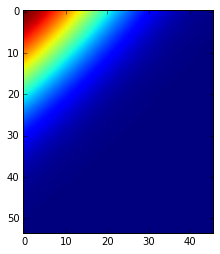

In [63]:
#46, 54 stands for the pixel size of one modis pixel in the sent2 coords after transform
plt.imshow(gaussian(54,46,2,5,45))

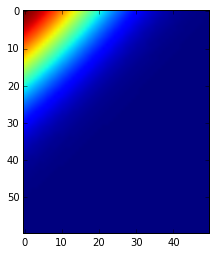

In [64]:
plt.imshow(gaussian(60,50,2,5,45))

In [4]:
from scipy import signal
import numpy as np
import scipy
from scipy import signal
import pylab as plt
%matplotlib inline
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus/(xgaus.sum()), ygaus/(ygaus.sum()))
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2.: center[0]+xwin/2., center[1]-ywin/2.:center[1]+ywin/2.]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

In [5]:
gaus = gaussian(100,100,2,5,45)

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
import numpy as np
from osgeo import ogr
from osgeo import osr
import mgrs
from scipy.interpolate import griddata

def transform(a=True):
    wgs84 = osr.SpatialReference( ) # Define a SpatialReference object
    wgs84.ImportFromEPSG( 4326 ) # And set it to WGS84 using the EPSG code
    modis_sinu = osr.SpatialReference() # define the SpatialReference object
    # In this case, we get the projection from a Proj4 string
    modis_sinu.ImportFromProj4 ( \
                    "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")
    if a:
        tx = osr.CoordinateTransformation(modis_sinu, wgs84)
    else:
        tx = osr.CoordinateTransformation(wgs84,modis_sinu)
    
    return tx

def get_mextend():
    
    tx = transform(False)
    
    m_lon1, modis_lat, modis_z = tx.TransformPoint (180, 0)
    m_lon0, modis_lat, modis_z = tx.TransformPoint (-180, 0)
    modis_lon, m_lat0, modis_z = tx.TransformPoint (0, 90)
    modis_lon, m_lat1, modis_z = tx.TransformPoint (0, -90)
    
    return (m_lon0, m_lon1, m_lat0, m_lat1)

def get_steps():
    m_lon0, m_lon1, m_lat0,m_lat1 = get_mextend()
    
    lon_step = (m_lon1-m_lon0)/36.
    lat_step = (m_lat0-m_lat1)/18.
    lon_cstep = lon_step/2400.
    lat_cstep = lon_step/2400.
    
    return (lon_step, lat_step, lon_cstep, lat_cstep)

def get_lon_lat(h, v):
    
    tx = transform(True)
    
    #m_lon, m_lat, m_z = tx.TransformPoint(lon, lat)
    
    lon_step, lat_step, lon_cstep, lat_cstep = get_steps()
    
    m_lon0, m_lon1, m_lat0, m_lat1 = get_mextend()
    
    h_0 = (h)*lon_step + m_lon0 ; v_0 = m_lat0 - (v)*lat_step 
    h_e = (h+1)*lon_step + m_lon0; v_e = m_lat0 - (v+1)*lat_step 

    hs = np.arange(h_0, h_e, lon_cstep)[0:2400]
    vs = np.arange(v_e, v_0, lat_cstep)[0:2400][::-1]
    
    h_array = np.tile(hs, 2400).reshape(2400,2400).ravel()
    v_array = (np.tile(vs, 2400).reshape(2400,2400).T).ravel()
    
   
    
    wgs = tx.TransformPoints(zip(h_array,v_array))
    m = mgrs.MGRS()
    
    mgr = []
    for i in wgs:
        mgr.append(m.toMGRS(i[1], i[0],MGRSPrecision=4))

    return np.array(mgr).reshape(2400,2400)


Gaus should goes through the same process like the coordination transform, then each pixels coordinates should be found. However, we only need the shape of the gaus not excactly the geo_coords, so we can use a arbitrary point for the transformation.

In [87]:
import sys
sys.path.insert(0,'python')
from geo_trans import *
lon_step, lat_step, lon_cstep, lat_cstep = get_steps()

In [88]:
lon_step/lon_cstep

2400.0

In [89]:
lon_cstep, lat_cstep

(463.3127165693848, 463.3127165693848)

In [90]:
tx = transform(True) # the gebo_transform function from geo_trans

In [91]:
m_lon0, m_lon1, m_lat0, m_lat1 = get_mextend()

h_0 = m_lon0 ; v_0 = m_lat0

h_e = 2*lon_cstep + m_lon0+27*lon_step+50; v_e = m_lat0 - 2*lat_cstep-5*lat_step-50

hs = np.arange(h_0+27*lon_step, h_e, (h_e-h_0-27*lon_step)/100)
vs = np.arange(v_e, v_0-5*lat_step, (v_0-v_e-5*lat_step)/100)[:100][::-1]

lon_array = np.tile(hs, 100).reshape(100,100)
lat_array = (np.tile(vs, 100).reshape(100,100).T)

<matplotlib.colorbar.Colorbar instance at 0x7f73b40926c8>

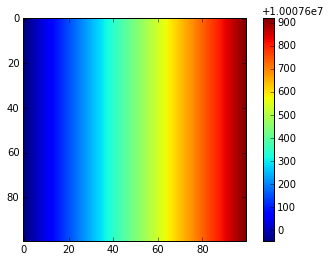

In [92]:
import pylab as plt
%matplotlib inline
plt.imshow(lon_array)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f73721f0290>

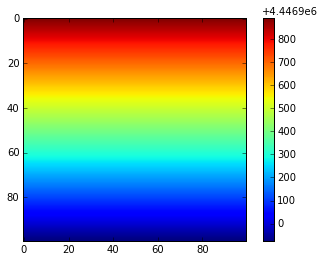

In [93]:
plt.imshow(lat_array)
plt.colorbar()

In [94]:
coords = zip(lon_array.ravel(), lat_array.ravel())
wgs = tx.TransformPoints(coords)
m = mgrs.MGRS()
mgr = []
for i in wgs:
    mgr.append(m.toMGRS(i[1], i[0],MGRSPrecision=4))
mgrss = np.array([(i[:5],i[-8:-4],i[-4:]) for i in mgr])
inds = mgrss[:,1:].astype(int)
inds[:,1] = 9999-inds[:,1]

In [95]:
len(np.unique(inds[:,1]))

99

In [96]:
a = np.zeros((10000,10000))
a[:] = np.nan

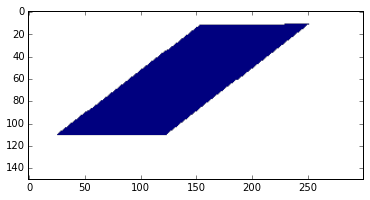

In [97]:
a[inds[:,1], inds[:,0]] = 1
plt.imshow(a[7200:7350, 4000:4300])

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


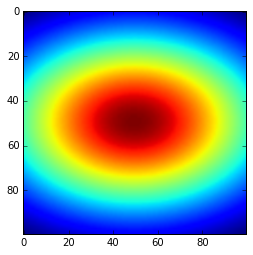

In [98]:
gaus = gaussian(100,100, 20,30,0)
plt.imshow(gaus)

In [99]:
inds[:,1] = inds[:,1] - (inds[:,1]).min()

In [100]:
inds[:,0] = inds[:,0] - (inds[:,0]).min()

In [101]:
import cPickle as pkl
pkl.dump(inds.T, open('pkls/gaus_trans.pkl', 'wb'))

In [25]:
import sys
sys.path.insert(0,'python')
from fast_rw import *
stm = parallel_rw_pkl(None, 'std_m', 'r')

In [48]:
indxs = np.array(np.where(stm==24000))

In [49]:
x = indxs[0]-indxs[0].min()
y = indxs[1]-indxs[1].min()

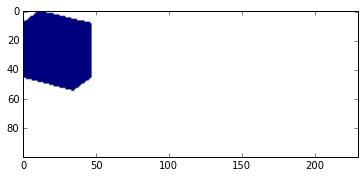

In [50]:
b = np.zeros((10000,10000))
b[:] = np.nan
b[x, y] = 1
plt.imshow(b[:100, :230])

In [51]:
len(np.unique(inds[1]))/2

49

In [52]:
mask = (inds[1] == len(np.unique(inds[1]))/2)

In [53]:
mid = ((inds[0])[mask])
mid[len(mid)/2-1]

113

In [54]:
center = [113, 49]

In [55]:
lenx = x.max()-x.min()
leny = y.max()-y.min()
cent = [lenx/2,leny/2]
shift = np.array(center)-np.array(cent)

In [56]:
x += shift[1]
y += shift[0]

In [57]:
x,y

(array([26, 27, 27, ..., 79, 80, 80]),
 array([ 97,  95,  96, ..., 121, 119, 120]))

In [58]:
b = np.zeros((10000,10000))
a = b.copy()
a[:] = np.nan
a[inds[1], inds[0]] = gaus.ravel()

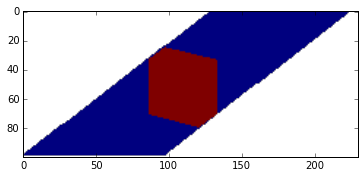

In [59]:
a[x-1, y] = 1
plt.imshow(a[:100, :230])

In [40]:
valid = a[x-1, y]

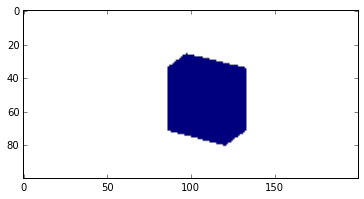

In [41]:
final = np.zeros((100,200))
final[:] = np.nan
final[x, y] = valid
plt.imshow(final)

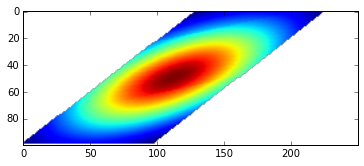

In [60]:
c = np.zeros((100,250))
c[:] = np.nan
c[inds[1], inds[0]] = gaus.ravel()
plt.imshow(c)

In [72]:
valid = c[x-2, y]

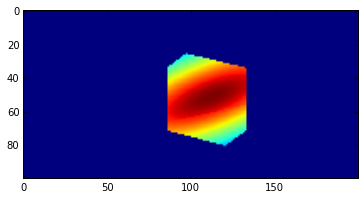

In [73]:
final = np.zeros((100,200))
#final[:] = np.nan
final[x, y] = valid
plt.imshow(final)

In [78]:
c = np.array([x-2, y])

In [80]:
import cPickle as pkl
pkl.dump(inds, open('pkls/gaus_trans.pkl','wb'))
pkl.dump(c, open('pkls/gaus_valid.pkl','wb'))

In [102]:
import cPickle as pkl
inds = pkl.load(open('pkls/gaus_trans.pkl','rb'))
x,y = pkl.load(open('pkls/gaus_valid.pkl','rb'))

In [103]:
a = np.zeros((100, 250))
a[inds[1], inds[0]] = gaus.ravel()

<matplotlib.colorbar.Colorbar instance at 0x7f720f9f1290>

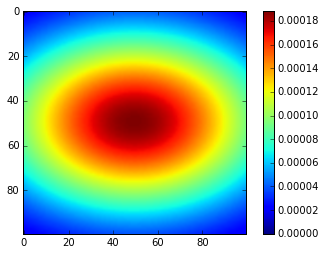

In [104]:
plt.figure(figsize=(6,4))
plt.imshow(gaus, vmin=0)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f720f8c3f38>

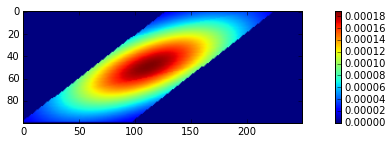

In [105]:
plt.figure(figsize=(12,2))
plt.imshow(a)
plt.colorbar()

In [106]:
valid = a[x,y]

In [107]:
x = x-x.min()
y = y-y.min()

0.99999999999999989

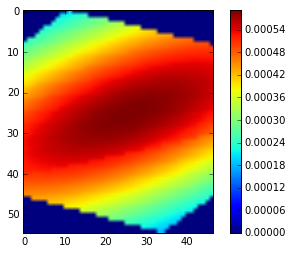

In [109]:
winx = x.max()+1
winy = y.max()+1
final = np.zeros((winx,winy))
#final[:] = np.nan
final[x, y] = valid
normed = final/final.sum()
plt.imshow(normed)
plt.colorbar()
normed.sum()

Basically, what I need for the geotransformation of gaussian to the sentinel is two indexes, one is for the projection of gaussianto to the sentinel and one is for the valid patch of gaussian that cover the interpolated pixel.